<a href="https://colab.research.google.com/github/Nov05/Google-Colaboratory/blob/master/20230911_deberta_v3_base_accelerate_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **\<BEGIN>**

* notebook origin: Kaggle [@shreydan](https://www.kaggle.com/code/shreydan/deberta-v3-base-accelerate-finetuning/notebook)  
* modified by nov05 on 2023-09-11  

👉 **READ**  
* [Migrating your code to HuggingFace **Accelerate**](https://huggingface.co/docs/accelerate/basic_tutorials/migration)  
* [Letting Accelerate handle gradient accumulation](https://huggingface.co/docs/accelerate/usage_guides/gradient_accumulation)
* [**attention mask**, huggingface transformer documentation v3.1.0](https://huggingface.co/transformers/v3.1.0/glossary.html#:~:text=The%20attention%20mask%20is%20a,0%20indicates%20a%20padded%20value.)   



# **🤗 Training With HuggingFace Accelerate + Pytorch Custom Trainer**

✅ we are using **deberta-v3-base** (frozen) + **mean pooling** with attention mask + 2 **fully-connected** layers as our model to train.  
✅ in this notebook, we also tested out different ways to save and load a model, and how to resume its training.  


* [W&B reference notebook](https://drive.google.com/file/d/14Zsob3b04rcRjVVgoXQI38tZ3lArs9JC)

⚠️ remember to restart the runtime after the installation of sentencepiece

In [1]:
%%capture
# !pip install transformers ## Successfully installed huggingface-hub-0.17.0 safetensors-0.3.3 tokenizers-0.13.3 transformers-4.33.1
# !pip install accelerate ## Successfully installed accelerate-0.22.0
# !pip install sentencepiece ## Successfully installed sentencepiece-0.1.99
# !pip install wandb ## version 0.15.10

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import AutoModel
from transformers import AutoTokenizer
from accelerate import Accelerator
import wandb
from tqdm.notebook import tqdm
import gc
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_NOTEBOOK_NAME"] = "20230911_deberta-v3-base-accelerate-finetuning.ipynb"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **dowloads**

In [4]:
## kaggle dir
# df = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
# test_df = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')
## google drive
url_train = 'https://drive.google.com/uc?id=1qa31ST7FgmgcaZaEwu3K2AKyu_8AnHZL'
url_test = 'https://drive.google.com/uc?id=1KmhuKX_0ilDhhkANzupapT4l9SH4DHCD'
url_submission = 'https://drive.google.com/uc?id=1LXITrcbWR51Ej2nyMxI5UpqLA5kq1hJ0'
df = pd.read_csv(url_train) ## will be split into train_df and val_df later
test_df = pd.read_csv(url_test)
print(df.columns.to_list())
print(test_df.columns.to_list())
test_df.head()

['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
['text_id', 'full_text']


,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


# **constants**  

In [5]:
CLASSES = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']

# **config**  

* the original notebook says about the batch size that "any number larger than 8 causes in CUDA OOM for unfreezed encoder on Kaggle GPU". however, it seems in google colab, batch_size=8 only uses about 3.2 GB of the 15 GB GPU RAM, which indicates batch size could be larger here? alright, 3.2 GB is the RAM needed when deberta-v3-base parameters are frozen.     

In [57]:
config = {
    'model': 'microsoft/deberta-v3-base', ## name or path
    'dropout': 0.5,
    'max_length': 512,
    'batch_size': 16, ## any number larger than 8 causes in CUDA OOM for unfreezed encoder on Kaggle GPU
    'epochs': 10,
    'lr': 3e-4,
    'enable_scheduler': True,
    'scheduler': 'CosineAnnealingWarmRestarts',
    'gradient_accumulation_steps': 2,
    'adam_eps': 1e-6, # 1e-8 default
    'freeze_encoder': True,
    'wandb': True,
    'epochs_saved': 0
}

In [7]:
tokenizer = AutoTokenizer.from_pretrained(config['model'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
run = wandb.init(project='deberta-v3-base-accelerate-finetuning',
                 name=config["model"],
                 group=config["model"],
                 job_type="training",
                 config=config)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find 20230911_deberta-v3-base-accelerate-finetuning.ipynb.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


```
Tracking run with wandb version 0.15.10
Run data is saved locally in /content/wandb/run-20230914_214546-ef7a2sek
Syncing run microsoft/deberta-v3-base to Weights & Biases (docs)
View project at https://wandb.ai/novemberfifth/deberta-v3-base-accelerate-finetuning
View run at https://wandb.ai/novemberfifth/deberta-v3-base-accelerate-finetuning/runs/ef7a2sek
```

# **dataset**  

In [9]:
class EssayDataset(Dataset):
    def __init__(self, df, config, tokenizer=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.classes = CLASSES
        self.max_len = config['max_length']
        self.tokenizer = tokenizer
        self.is_test = is_test


    def __getitem__(self, idx):
        sample = self.df['full_text'][idx]
        tokenized = tokenizer.encode_plus(sample,
                                          None,
                                          add_special_tokens=True,
                                          max_length=self.max_len,
                                          truncation=True,
                                          padding='max_length')
        inputs = {
            "input_ids": torch.tensor(tokenized['input_ids'], dtype=torch.long),
            "token_type_ids": torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
            "attention_mask": torch.tensor(tokenized['attention_mask'], dtype=torch.long)
        }
        if self.is_test:
            return inputs
        else:
            labels = self.df.loc[idx, self.classes].to_list()
            targets = {"labels": torch.tensor(labels, dtype=torch.float32)}
            return inputs, targets


    def __len__(self):
        return len(self.df)

In [10]:
## code explain
labels = df.loc[0, CLASSES].to_list()
torch.tensor(labels, dtype=torch.float32)

tensor([3.5000, 3.5000, 3.0000, 3.0000, 4.0000, 3.0000])

In [11]:
train_df, val_df = train_test_split(df,
                                    test_size=0.2,
                                    random_state=1357,
                                    shuffle=True)
print('dataframe shapes:', train_df.shape, val_df.shape)

dataframe shapes: (3128, 8) (783, 8)


In [12]:
## convert data to Dataset objects
train_ds = EssayDataset(train_df, config, tokenizer=tokenizer)
val_ds = EssayDataset(val_df, config, tokenizer=tokenizer)
test_ds = EssayDataset(test_df, config, tokenizer=tokenizer, is_test=True)
train_ds[0][0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [13]:
train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=config['batch_size'],
                                           shuffle=True,
                                           num_workers=2,
                                           pin_memory=True
                                          )
val_loader = torch.utils.data.DataLoader(val_ds,
                                         batch_size=config['batch_size'],
                                         shuffle=True,
                                         num_workers=2,
                                         pin_memory=True
                                        )

In [14]:
print('loader lengths:', len(train_loader), len(val_loader))

loader lengths: 391 98


# **model**

## **mean pooling layer**  

Mean Pooling src from [@debarshichanda](https://www.kaggle.com/code/debarshichanda/fb3-custom-hf-trainer-w-b-starter?scriptVersionId=104880636&cellId=24)


In [15]:
class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

## **✅ the main model**   

**deberta-v3-base** (frozen) + **mean pooling** with attention mask + 2 **fully-connected** layers

In [16]:
class EssayModel(nn.Module):
    def __init__(self, config:dict, num_classes=6):
        super().__init__()
        self.model_name = config['model']
        self.freeze = config['freeze_encoder']

        ## freeze the original model
        self.encoder = AutoModel.from_pretrained(self.model_name)
        if self.freeze:
            for param in self.encoder.base_model.parameters():
                param.requires_grad = False

        ## attach mean-pooling and fully-connected layers
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(config['dropout'])
        self.fc1 = nn.Linear(self.encoder.config.hidden_size,64)
        self.fc2 = nn.Linear(64, num_classes)


    def forward(self, inputs):
        outputs = self.encoder(**inputs, return_dict=True) ## kwarg expansion is not supported by torch script
        outputs = self.pooler(outputs['last_hidden_state'], inputs['attention_mask'])
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        return outputs

⚠️ using `outputs = self.encoder(inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask'], return_dict=True)` rather than `outputs = self.encoder(**inputs, return_dict=True)`.  
```
inputs = {
    "input_ids": torch.tensor(tokenized['input_ids'], dtype=torch.long),
    "token_type_ids": torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
    "attention_mask": torch.tensor(tokenized['attention_mask'], dtype=torch.long)
}
```

In [17]:
## code explain
for inputs,targets in train_loader:
    print(inputs)
    break

{'input_ids': tensor([[     1,  10147,    294,  ...,    297,   1300,      2],
        [     1,    273,   1757,  ...,      0,      0,      0],
        [     1, 101946,    314,  ...,      0,      0,      0],
        ...,
        [     1,   1388,    273,  ...,    722,    280,      2],
        [     1,    273,   1757,  ...,      0,      0,      0],
        [     1,    771,    274,  ...,    879,    652,      2]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])}


# **trainer**
<div style="width:100%;height:0;border-bottom: 3px solid #e7eb1a;margin-bottom: 1rem;"></div>

https://huggingface.co/docs/accelerate/usage_guides/memory  


In [64]:
class Trainer:
    def __init__(self, model, train_val_loaders, config, accelerator):
        self.model = model ## model object
        self.config = config ## config dict
        self.accelerator = accelerator ## accelerate object
        self.input_keys = ['input_ids', 'token_type_ids', 'attention_mask']

        ## if a saved model is loaded for inference only, there won't be train-val loaders etc.
        if train_val_loaders:
            self.train_loader, self.val_loader = train_val_loaders
            self.optim = self._get_optim()
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                self.optim,
                T_0=5,
                eta_min=1e-7)
            self.train_losses = []
            self.val_losses = []


    def accelerator_prepare(self):
        self. model, self.optim, self.train_loader, self.val_loader, self.scheduler \
            = self.accelerator.prepare(self.model,
                                       self.optim,
                                       self.train_loader,
                                       self.val_loader,
                                       self.scheduler)


    def wandb_init(self):
        run = wandb.init(project='deberta-v3-base-accelerate-finetuning',  ## notebook name or path
                         name=self.config["model"],
                         group=self.config["model"],
                         job_type="training",
                         config=self.config)
        return run


    def _get_optim(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n,p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n,p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.config['lr'], eps=self.config['adam_eps'])
        return optimizer


    def loss_fn(self, outputs, targets):
        colwise_mse = torch.mean(torch.square(targets - outputs), dim=0)
        loss = torch.mean(torch.sqrt(colwise_mse), dim=0)
        return loss


    def train_one_epoch(self, epoch):
        self.model.train()
        running_loss = 0.
        progress = tqdm(self.train_loader, total=len(self.train_loader))
        for idx,(inputs,targets) in enumerate(progress):
            with self.accelerator.accumulate(self.model):
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets['labels'])
                running_loss += loss.item()
                self.accelerator.backward(loss)
                self.optim.step()
                if self.config['enable_scheduler']:
                    ## AttributeError: 'tuple' object has no attribute 'step'
                    ## got this error, which was caused by calling a wrong trainer function name
                    self.scheduler.step(epoch - 1 + idx/len(self.train_loader))
                self.optim.zero_grad()
                del inputs, targets, outputs, loss
        train_loss = running_loss / len(self.train_loader)
        self.train_losses.append(train_loss)
        self.clear()


    @torch.no_grad()
    def eval_one_epoch(self, epoch):
        self.model.eval()
        running_loss = 0.
        eval_progress = tqdm(self.val_loader, total=len(self.val_loader), desc="evaluating...")
        for (inputs,targets) in eval_progress:
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets['labels'])
            running_loss += loss.item()
            del inputs, targets, outputs, loss
        val_loss = running_loss / len(self.val_loader)
        self.val_losses.append(val_loss)
        if self.config['wandb']:
            wandb.log({"loss": val_loss,
                       "lr": self.scheduler.get_lr()[0]})
        self.clear()


    def train(self):
        if self.config['wandb']: self.wandb_init()
        self.accelerator_prepare()
        saved = self.config['epochs_saved']
        train_progress = tqdm(range(1+saved, self.config['epochs']+1+saved),
                              leave=True,
                              desc="training...")
        for epoch in train_progress:
            train_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']+saved} | training...")
            self.train_one_epoch(epoch)
            train_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']+saved} | validating...")
            self.eval_one_epoch(epoch)
            print(f"{'='*10} EPOCH {epoch} / {self.config['epochs']+saved} {'='*10}")
            print(f"train loss: {self.train_losses[-1]}")
            print(f"val loss: {self.val_losses[-1]}\n\n")


    def test(self, test_loader):
        preds = []
        self.model, test_loader = self.accelerator.prepare(self.model, test_loader)
        test_progress = tqdm(test_loader, total=len(test_loader), desc="testing...")
        for (inputs) in test_progress:
            outputs = self.model(inputs)
            preds.append(outputs.detach().cpu())
        preds = torch.concat(preds)
        self.clear()
        return preds


    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()

# **training**

In [ ]:
if __name__ == '__main__':
    accelerator = Accelerator(gradient_accumulation_steps=config['gradient_accumulation_steps'])
    model = EssayModel(config).to(device=accelerator.device)
    trainer = Trainer(model, (train_loader, val_loader), config, accelerator)
    trainer.train()
    if config.wandb: wandb.finish()
## on GPU T4, batch size=8, each epoch took about 3 minutes

training...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 1 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.7309528715775141
val loss: 0.492062796135338




  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 2 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.47011323932491605
val loss: 0.4717295172871376




  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 3 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4574219207172199
val loss: 0.47949915789828007




  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 4 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.45255269807622867
val loss: 0.4684644131636133




  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 5 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.44816778535428253
val loss: 0.4775970185897788




  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 6 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.45473267492430897
val loss: 0.45467731508673453




  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 7 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.45029663208805387
val loss: 0.49911369383335114




# **results**
<div style="width:100%;height:0;border-bottom: 3px solid #EAB209;margin-bottom: 1rem;"></div>

In [ ]:
losses_df = pd.DataFrame({'epoch':list(range(1,config['epochs'] + 1)),
                          'train_loss':trainer.train_losses,
                          'val_loss': trainer.val_losses
                         })
losses_df

,epoch,train_loss,val_loss
0,1,0.730953,0.492063
1,2,0.470113,0.471730
2,3,0.457422,0.479499
3,4,0.452553,0.468464
4,5,0.448168,0.477597
5,6,0.454733,0.454677
6,7,0.450297,0.499114


##  **plots**
<div style="width:100%;height:0;border-bottom: 3px solid #EDD608;margin-bottom: 1rem;"></div>

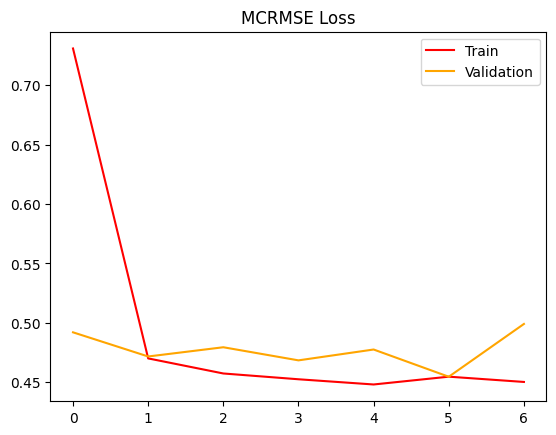

In [ ]:
plt.plot(trainer.train_losses, color='red')
plt.plot(trainer.val_losses, color='orange')
plt.title('MCRMSE Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# **save model**

* joblib file: 701.6 MB  
* state dict (.pth) file: 701.5 MB  
* checkpoint of epoch, optimizer, train_loss, val_loss: 392 KB  


## **save with joblib**  

⚠️ if using joblib, models need to be created under `if __name__ == "__main__":`, or it can't be opened outside notebook env.  
https://stackoverflow.com/questions/49621169/joblib-load-main-attributeerror  
```
...
  File "D:\Users\guido\miniconda3\envs\kaggle--feedback-prize-ell\Lib\pickle.py", line 1582, in find_class
    return _getattribute(sys.modules[module], name)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Users\guido\miniconda3\envs\kaggle--feedback-prize-ell\Lib\pickle.py", line 331, in _getattribute
    raise AttributeError("Can't get attribute {!r} on {!r}"
AttributeError: Can't get attribute 'EssayModel' on <module '__main__' from 'd:\\github\\kaggle--feedback-prize-ell\\main.py'>
```

In [ ]:
import joblib
save_model_to_path = "/content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/00_7epochs.joblib" ## 701.6 MB

if __name__ == "__main__":
    # model = EssayModel(config).to(device=accelerator.device)
    # joblib.dump(trainer.model, save_model_to_path)

!ls -l $save_model_to_path
## -rw------- 1 root root 735628768 Sep 14 08:48 /content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/00_7epochs.joblib

## **✅ save state dict (.pth)**  

👉 [PyTorch Saving & Loading Model for Inference](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)   

In [ ]:
save_model_to_path = "/content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/00_7epochs.pth" ## 701.5 MB
# torch.save(model.state_dict(), save_model_to_path)
!ls -l $save_model_to_path

-rw------- 1 root root 735609233 Sep 12 01:31 /content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/00_7epochs.pth


## **save the entire model (pickle)**  

In [ ]:
## this is equivalent to pickle
# torch.save(model, PATH)
# # Model class must be defined somewhere
# model = torch.load(PATH)
# model.eval()

## **save in TorchScript format (.pt)**  

⚠️ got this error: `NotSupportedError: keyword-arg expansion is not supported`.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;it is the deberta module, which was called with kwarg `self.encoder(**inputs, return_dict=True)`.     
⚠️ got this error: `RuntimeError:
Module 'DebertaV2Embeddings' has no attribute 'config'`   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;it is the `EssayModel(config)` that caused the problem.   
Anyway, I gave up on using this method to save this model.  


In [ ]:
## Using the TorchScript format, you will be able to load the exported
## model and run inference without defining the model class.

## export
# model = EssayModel(config)
# save_model_to_path = "/content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/test.pt"
# model_scripted = torch.jit.script(model) ## Export to TorchScript
# model_scripted.save(save_model_to_path) ## Save

## load
# model = torch.jit.load('model_scripted.pt')
# model.eval()

```
---------------------------------------------------------------------------
NotSupportedError                         Traceback (most recent call last)
<ipython-input-30-ea4bef4f8807> in <cell line: 5>()
      3 ## export
      4 save_model_to_path = "/content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/00_7epochs_scripted.pt"
----> 5 model_scripted = torch.jit.script(model) ## Export to TorchScript
      6 model_scripted.save(save_model_to_path) ## Save
      7 ## load

13 frames
/usr/local/lib/python3.10/dist-packages/torch/jit/frontend.py in build_Call(ctx, expr)
    751             # XXX: we could do a better job at figuring out the range for the name here
    752             if not kw.arg:
--> 753                 raise NotSupportedError(kw_expr.range(), 'keyword-arg expansion is not supported')
    754             kwargs.append(Attribute(Ident(kw_expr.range(), kw.arg), kw_expr))
    755         return Apply(func, args, kwargs)

NotSupportedError: keyword-arg expansion is not supported:
  File "<ipython-input-14-17bc30e25e1b>", line 21
    def forward(self,inputs):
        outputs = self.encoder(**inputs,return_dict=True)
                                 ~~~~~~ <--- HERE
        outputs = self.pooler(outputs['last_hidden_state'], inputs['attention_mask'])
        outputs = self.fc1(outputs)
```

```
RuntimeError:
Module 'DebertaV2Embeddings' has no attribute 'config' (This attribute exists on the Python module, but we failed to convert Python type: 'transformers.models.deberta_v2.configuration_deberta_v2.DebertaV2Config' to a TorchScript type. Only tensors and (possibly nested) tuples of tensors, lists, or dictsare supported as inputs or outputs of traced functions, but instead got value of type DebertaV2Config.. Its type was inferred; try adding a type annotation for the attribute.):
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/deberta_v2/modeling_deberta_v2.py", line 894
        if self.position_biased_input:
            embeddings += position_embeddings
        if self.config.type_vocab_size > 0:
           ~~~~~~~~~~~ <--- HERE
            token_type_embeddings = self.token_type_embeddings(token_type_ids)
            embeddings += token_type_embeddings
```

## **✅ save checkpoint**   
👉 [Saving & Loading a General Checkpoint for Inference and/or Resuming Training](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training)  

```
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            ...
            }, PATH)
```

In [ ]:
## since the state dict has been save before, it will be skipped here
save_model_to_path = "/content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/00_7epochs.checkpoint" ## 392 KB
torch.save({
            'epoch': config['epochs_saved'] + config['epochs'],
            # 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': trainer.optim.state_dict(),
            'train_losses': trainer.train_losses,
            'val_losses': trainer.val_losses,
            }, save_model_to_path)

```
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()
```

# **load model**   

## **from state dict (.pth)**  

⚠️ execute all the cells before the `training` cell.

In [46]:
%%time
PATH = "/content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/00_7epochs.pth"
if __name__ == '__main__':
    model = EssayModel(config)
    model.load_state_dict(torch.load(PATH, map_location='cuda'))
## RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False.
## If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.
## <All keys matched successfully>

CPU times: user 2.64 s, sys: 1.1 s, total: 3.74 s
Wall time: 5.25 s


In [43]:
accelerator = Accelerator(gradient_accumulation_steps=config['gradient_accumulation_steps'])
trainer = Trainer(model, None, config, accelerator)
test_loader = torch.utils.data.DataLoader(test_ds,
                                        batch_size=config['batch_size'],
                                        shuffle=True,
                                        num_workers=2,
                                        pin_memory=True)
print(accelerator.device)

cuda


In [44]:
%time
y_preds = trainer.test(test_loader)
y_preds
## 3 entries took 10~21 seconds on CPU... 😵‍💫

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


testing...:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[2.9175, 2.7833, 3.3462, 3.0583, 2.7687, 2.7392],
        [3.6729, 3.4569, 3.8462, 3.6960, 3.4865, 3.4645],
        [2.8027, 2.4867, 3.1199, 2.5106, 2.2230, 2.8316]])

## **load from joblib file**  

⚠️ execute all the cells before the `training` cell.  
⚠️ since the model was save from GPU, it has to be loaded back to GPU. It is unlike models saved as state dict (.pth), which are managed by torch, and can be loaded to CPU.    
✅ one of the pros to use joblib is that you don't need the model class definition for inference-only tasks.  

In [18]:
import joblib
PATH = "/content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/00_7epochs.joblib"
model = joblib.load(PATH)
accelerator = Accelerator(gradient_accumulation_steps=config['gradient_accumulation_steps'])
trainer = Trainer(model, None, config, accelerator)
test_loader = torch.utils.data.DataLoader(test_ds,
                                          batch_size=config['batch_size'],
                                          shuffle=True,
                                          num_workers=2,
                                          pin_memory=True)

In [ ]:
## torch.load() threw the following error
## RuntimeError: Invalid magic number; corrupt file?
if 0:
    import joblib
    PATH = "/content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/00_7epochs.joblib"
    model = torch.load(PATH, map_location=torch.device('cpu'))
## RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False.
## If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [26]:
for input in test_loader:
    print(input)
    print(input['input_ids'].device)
    break

{'input_ids': tensor([[   1,  335,  266,  ...,  265,  262,    2],
        [   1, 2651, 9805,  ...,    0,    0,    0],
        [   1,  771,  274,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
cpu


In [33]:
## tried to move the model to cpu and infer there
## the accelerator caused the following problem! if GPU is available, it will use GPU.
## RuntimeError: Expected all tensors to be on the same device, but found at least two devices,
## cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)
model.to('cpu') ## this does work.
y_preds = []
# y_preds = trainer.test(test_loader)
# test_loader = accelerator.prepare(test_loader) ## here is the problem
test_progress = tqdm(test_loader, total=len(test_loader), desc="testing...")
for (inputs) in test_progress:
    outputs = model(inputs)
    y_preds.append(outputs.detach().cpu())
y_preds = torch.concat(y_preds)
y_preds
## now it can infer on CPU. 3 test data entries took 17 seconds.

testing...:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[2.8027, 2.4867, 3.1199, 2.5106, 2.2230, 2.8316],
        [3.6729, 3.4569, 3.8462, 3.6960, 3.4865, 3.4645],
        [2.9175, 2.7833, 3.3462, 3.0583, 2.7687, 2.7392]])

In [34]:
%time
model.to('cuda')
y_preds = trainer.test(test_loader) ## # test_loader = accelerator.prepare(test_loader), it will make sure all tensors are on GPU.
y_preds
## now back to GPU

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


testing...:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[2.8027, 2.4867, 3.1199, 2.5106, 2.2230, 2.8316],
        [2.9175, 2.7833, 3.3462, 3.0583, 2.7687, 2.7392],
        [3.6729, 3.4569, 3.8462, 3.6960, 3.4865, 3.4645]])

In [ ]:
df_ds = EssayDataset(df, config, tokenizer=tokenizer, is_test=True)
df_loader = torch.utils.data.DataLoader(df_ds,
                                        batch_size=config['batch_size'],
                                        shuffle=True,
                                        num_workers=2,
                                        pin_memory=True)
y_preds = trainer.test(df_loader)
## test data entry number 3911, batch size 8, 489 batches
## it took about 2 min to refer on GPU T4

  0%|          | 0/489 [00:00<?, ?it/s]

# **✅ restart training**    

In [61]:
PTH_PATH = "/content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/00_30epochs.pth"
CHECKPOINT_PATH = "/content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/00_30epochs.checkpoint"

if __name__ == '__main__': ## if using pickle or joblib to save the model; using state dict is fine
    model = EssayModel(config)
    model.load_state_dict(torch.load(PTH_PATH, map_location='cuda'))
    trainer = Trainer(model, (train_loader, val_loader), config, accelerator)

    checkpoint = torch.load(CHECKPOINT_PATH)
    # model.load_state_dict(checkpoint['model_state_dict'])
    trainer.optim.load_state_dict(checkpoint['optimizer_state_dict'])
    trainer.train_losses = checkpoint['train_losses']
    trainer.val_losses = checkpoint['val_losses']
    config['epochs_saved'] = checkpoint['epoch']

    trainer.train()
    if config['wandb']: wandb.finish()

wandb: Currently logged in as: nov05 (novemberfifth). Use `wandb login --relogin` to force relogin


training...:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 8 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.43694507115332365
val loss: 0.4766742255614728




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 9 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4326733192214576
val loss: 0.4662684104880508




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 10 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.42996003118622333
val loss: 0.46922124435707013




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 11 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4384287022568686
val loss: 0.4772685872656958




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 12 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4401419758796692
val loss: 0.5222394223115883




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 13 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4364964715812517
val loss: 0.47018193468755604




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 14 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4314631023980163
val loss: 0.4785479471391561




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 15 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.42706072985973503
val loss: 0.4705566514511498




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 16 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4377438230130374
val loss: 0.4929012981604557




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 17 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4370786024024115
val loss: 0.4858758045094354




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 18 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.43141920144295753
val loss: 0.45724227537914197




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 19 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.42780354352253475
val loss: 0.4758127286117904




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 20 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4244910061664289
val loss: 0.4705260234827898




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 21 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4351835213506313
val loss: 0.467781452195985




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 22 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4342426510570604
val loss: 0.47849430904096485




  0%|          | 0/391 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 23 / 23 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.42845705029604686
val loss: 0.45766209552482684




loss,▃▂▂▃█▂▃▂▅▄▁▃▂▂▃▁
lr,▄▂▁█▆▄▂▁█▆▄▂▁█▆▄
loss,0.45766
lr,0.0001


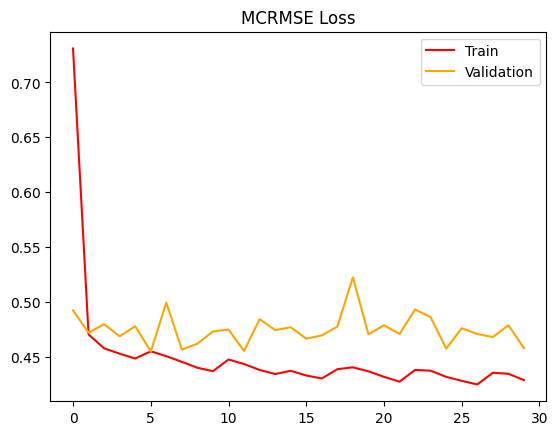

In [62]:
plt.plot(trainer.train_losses, color='red')
plt.plot(trainer.val_losses, color='orange')
plt.title('MCRMSE Loss')
plt.legend(['Train', 'Validation'], loc='upper right');

In [63]:
## i am saving the state dict and the rest data separately, for later i will only upload .pth to kaggle for inference
PTH_PATH = "/content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/00_30epochs.pth"
CHECKPOINT_PATH = "/content/drive/MyDrive/models/20230911_deberta-v3-base-accelerate-finetuning.ipynb/00_30epochs.checkpoint"
torch.save(model.state_dict(), PTH_PATH)
torch.save({
    'epoch': config['epochs_saved'] + config['epochs'],
    # 'model_state_dict': model.state_dict(),
    'optimizer_state_dict': trainer.optim.state_dict(),
    'train_losses': trainer.train_losses,
    'val_losses': trainer.val_losses,
    }, CHECKPOINT_PATH)

# **references**
<div style="width:100%;height:0;border-bottom: 3px solid #C3F307;margin-bottom: 1rem;"></div>

- optimization techniques: [by user @vad13irt](https://www.kaggle.com/code/vad13irt/optimization-approaches-for-transformers)
- gradient accumulation usage: [🤗 docs](https://huggingface.co/docs/accelerate/usage_guides/gradient_accumulation)
- accelerate: [🤗 docs](https://huggingface.co/docs/accelerate/basic_tutorials/migration)
- trainer: [using-transformers-for-the-first-time-pytorch](https://www.kaggle.com/code/shreydan/using-transformers-for-the-first-time-pytorch)

# **more to read**  

* https://github.com/huggingface/accelerate
* [How to avoid GPU Out-of-Memory (OOM) with Accelerate](https://huggingface.co/docs/accelerate/usage_guides/memory)  
* [How to use 🤗 Accelerate with Intel® Extension for PyTorch for cpu](https://huggingface.co/docs/accelerate/usage_guides/ipex)  

# **\<END>**